# Prediction of HOMO-LUMO Energy Gaps
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/HOMO-LUMO-prediction/notebooks/homo-lumo-gap.ipynb)

# Content

1. [Introduction](#1)
2. [Load DataSet](#2)
3. [Data Pre-processing](#3)
4. [Visualization](#4)
    - 4.1. [Draw from RDKit](#5)
    - 4.2. [Creat a DataFrame](#6)
5. [Avalon Fingerprints](#7)
    - 5.1. [Creating different nBits as Feature Inputs](#8)
        - 5.1.1 [nBits = 4096](#9)
        - 5.1.2 [nBits = 2048](#10)
        - 5.1.3 [nBits = 1024](#11)
        - 5.1.4 [nBits = 512](#12)
6. [Model Training: LGBMRegressor and Random Forest Regressor](#13)
    - 6.1. [nBits = 512](#14)
    - 6.2. [nBits = 1024](#15)
    - 6.3. [nBits = 2048](#16)
    - 6.4. [nBits = 4096](#17)
    - 6.5. [Analysis of the Results](#18)
    - 6.6. [Prediction with LGBMRegressor - 10 fold](#19)
        - 6.6.1 [Tran-test data split](#20)
        - 6.6.2 [Predicted vs Observation](#21)
        - 6.6.3 [Residual](#22)
        - 6.6.4 [Absolute Difference](#23)
7. [Conclusion](#24)

## 1. Introduction<a name = 1></a>

This project takes inspiration from the 2020 publication ["A Structure-Based Platform for Predicting Chemical Reactivity"](https://www-sciencedirect-com.lama.univ-amu.fr/science/article/pii/S2451929420300851). In this paper, the authors computed various chemical features with the goal of predicting chemical reactivity. Among the models they developed, one focused on predicting the HOMO-LUMO energy gap.

In this publication the authors highlight the importance of making sure that a set of molecules, which will be use as machine learning feature inputs to predict chemical reactions, have something in common. With that in mind, they got a fingerprint-based model where the tested the prediction of the HOMO-LUMO enegery gap from DFT calculations. This model got an average R^2 of 0.89 and a MAE in kcal/mol of 6.26 for a ten random 70/30 splits.

They selected all the chemical structures from the [QM9 dataset](http://dx.doi.org/10.1038/sdata.2014.22), which is quantum chemistry dataset of 134 kilo molecules calculated using Density Functional Theory (DFT) using 3LYP/6-31G(2df,p) level of quantum chemistry.

[Access the Dataset Here](https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool/-/blob/master/DataAndSoftware_S1-S4.zip?ref_type=heads)

The objective is to reproduce the results observed in the original publication.

In [1]:
!pip install rdkit

In [2]:
!pip install mols2grid

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem #Chemistry related RDKit module
from rdkit.Chem.Draw import IPythonConsole #Molecules visualization with Jupyter
from rdkit.Chem import Draw #2D depiction
from rdkit.Chem import rdDepictor #2D coordinate generation, consistency
from rdkit import DataStructs #RDKit data structure - binary fingerprints
from rdkit.Chem import PandasTools #RDKit with Pandas
from rdkit.Avalon import pyAvalonTools #Avalon fingerprint
import mols2grid #Molecule representation in a grid
IPythonConsole.ipython_useSVG = True #Molecules display in SGV in Jupyter
rdDepictor.SetPreferCoordGen(True) #Cleaner 2D coordinate generation


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split, KFold
from lightgbm import LGBMRegressor
from sklearn.feature_selection import VarianceThreshold

import time

## 2. Load DataSet<a name = 2></a>

In [4]:
dataset = pd.read_csv("orbital_energies.csv")
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


In [5]:
dataset.shape

(2904, 2)

Let's set the canonical SMILES to the dataset

In [6]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] # Chem.MolFromSmiles Convert a SMILES to an RDKit molecule object
    smiles = [Chem.MolToSmiles(mol) for mol in mols] # Chem.MolToSmiles converts the molecule back into its canonical SMILES representation
    return smiles

In [7]:
# Canonical SMILES
canon_smiles = canonical_smiles(dataset['SMILES'])

In [8]:
# Put the smiles in the dataframe
dataset['SMILES'] = canon_smiles
dataset

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


## 3. Data Pre-processing<a name = 3></a>

Let's check for **missing values**, **duplicates** and **fragments**

**Remove Missing Values**

In [9]:
dataset["SMILES"].isnull().sum()

0

**Remove Duplicates**

In [10]:
duplicated = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
duplicated

array(['N[C@@H](CCC(=O)O)C(=O)O', 'O=C(O)[C@H]1CCCN1', 'CI',
       'N[C@@H](Cc1ccccc1)C(=O)O', 'C=Cc1ccncc1',
       'O=C(/C=C/c1ccccc1)c1ccccc1', 'N[C@@H](CC(=O)O)C(=O)O',
       'O=C(O)[C@H]1CCCN1', 'N[C@@H](CO)C(=O)O', 'c1cnc2[nH]ccc2c1',
       'CC(C)C[C@@H](N)C(=O)O', 'C=CN1CCCC1=O',
       'CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O', 'CC1(C)[C@H]2CC=C(CO)[C@@H]1C2',
       'C1CC[C@H]2CCCC[C@@H]2C1', 'CSCC[C@@H](N)C(=O)O', 'O=C(O)c1ccccc1',
       'CO[C@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@@H]1O', 'C1=CCCCCCC1',
       'C=Cc1ccccc1', 'O=C1C=CCCC1', 'CCCCCCCC/C=C/CCCCCCCC(=O)O',
       'CC(C)I', 'C=Cc1ccccc1',
       'OC[C@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1O',
       'CC(C)(C)OC(=O)N1CCC(C(=O)O)CC1', 'CC(C)[C@@H](N)C(=O)O',
       'N[C@H]1CCCC[C@@H]1N', 'O=C1OC(=O)c2ncccc21', 'CC(C)[C@@H](N)CO',
       'CC(C)[C@@H](N)C(=O)O'], dtype=object)

In [11]:
dataset[dataset['SMILES'].isin(duplicated)].sort_values(by=['SMILES'])

,SMILES,Energygap
218,C1=CCCCCCC1,214.097913
2125,C1=CCCCCCC1,214.097913
1901,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
552,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
554,C=CN1CCCC1=O,190.834900
1808,C=CN1CCCC1=O,190.835527
2203,C=Cc1ccccc1,168.467969
1354,C=Cc1ccccc1,168.475499
2341,C=Cc1ccccc1,168.490559
1265,C=Cc1ccncc1,174.833420


In [12]:
dataset.shape

(2904, 2)

In [13]:
dataset_clean = dataset.drop_duplicates(subset=['SMILES'], keep='first').copy()

In [14]:
dataset_clean.shape

(2873, 2)

In [15]:
dataset_clean

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2900,Brc1cccc2sccc12,162.928319
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2902,c1ccc2sccc2c1,167.958431


In [16]:
dataset_clean.reset_index(drop=True, inplace=True)

In [17]:
dataset_clean

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.749421
1,O=C(O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,CC(C)=CCC[C@@H](C)CCO,209.569808
...,...,...
2868,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319
2869,Brc1cccc2sccc12,162.928319
2870,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245
2871,c1ccc2sccc2c1,167.958431


**Remove Fragments**

In some cases, a single SMILES string can represent multiple disconnected chemical structures. These disconnected structures are separated by a period (.) in the SMILES notation.

In [18]:
# Filter rows where 'SMILES' column contains a period
smiles_with_period = dataset_clean[dataset_clean['SMILES'].str.contains('\.', regex=True)]

# Display the number of such rows and the first few entries for context
num_rows_with_period = len(smiles_with_period)
num_rows_with_period, smiles_with_period.head()

(0,
 Empty DataFrame
 Columns: [SMILES, Energygap]
 Index: [])

## 4. Visualization<a name = 4></a>

### 4.1 Draw from RDKit<a name = 5></a>

RDKit function **Chem.MolFromSmiles** to covert a SMILES to a molecule object that can be depicted

In [19]:
mol_list = [Chem.MolFromSmiles(element) for element in dataset_clean['SMILES']]

In [20]:
len(mol_list)

2873

In [21]:
mol_list[:5]

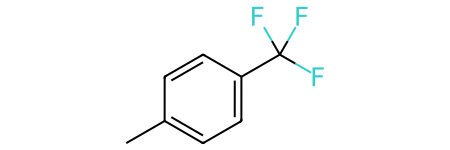

In [22]:
Chem.MolFromSmiles(dataset_clean['SMILES'].iloc[0])

### 4.2 Create a DataFrame<a name = 6></a>

In [23]:
# Creat a DataFrame from the mol_list
df_mol_list = pd.DataFrame(mol_list, columns=['Molecule'])

In [24]:
df_mol_list.head()

,Molecule
0,<rdkit.Chem.rdchem.Mol object at 0x7d43f519b450>
1,<rdkit.Chem.rdchem.Mol object at 0x7d43f519b4c0>
2,<rdkit.Chem.rdchem.Mol object at 0x7d43f519b530>
3,<rdkit.Chem.rdchem.Mol object at 0x7d43f519b5a0>
4,<rdkit.Chem.rdchem.Mol object at 0x7d43f519b610>


In [25]:
# Visualize the DataFrame of the molecules within a grid
mols2grid.display(df_mol_list,mol_col="Molecule")

MolGridWidget()

## 5. Avalon Fingerprints<a name = 7></a>

In [26]:
# Include 2D structure of molecules
PandasTools.AddMoleculeColumnToFrame(dataset_clean,'SMILES','Stucture')

,SMILES,Energygap,Stucture
0,Cc1ccc(C(F)(F)F)cc1,197.749421,
1,O=C(O)CCCCl,247.493942,
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327,
3,Nc1ccc(Cl)c(Cl)c1,169.027707,
4,CC(C)=CCC[C@@H](C)CCO,209.569808,
...,...,...,...
2868,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.649319,
2869,Brc1cccc2sccc12,162.928319,
2870,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.098245,
2871,c1ccc2sccc2c1,167.958431,

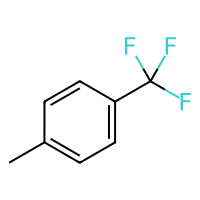
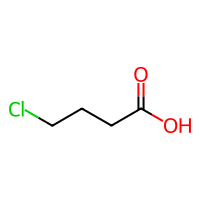
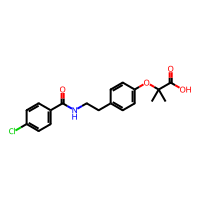
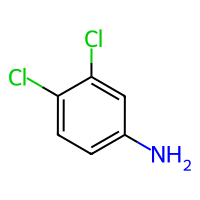
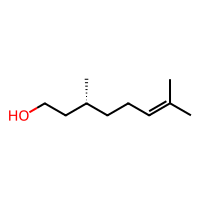
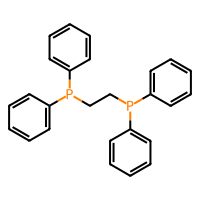
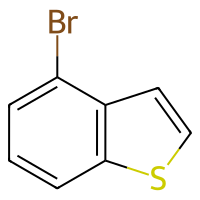
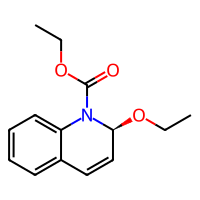
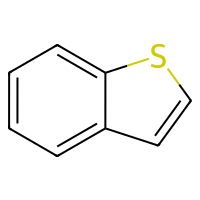
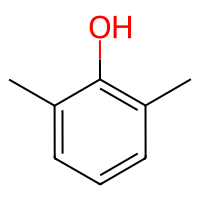

In [27]:
dataset_clean

In [28]:
def avalon_fps(data, nBits=2048): #To costume the desire nBits
    """Generate Avalon fingerprints for a list of SMILES strings.

    Parameters:
    - data (list of str): List of SMILES strings representing molecules.
    - nBits (int, optional): Desired size of the output fingerprint. Default is 2048 bits.

    Returns:
    - numpy.ndarray: An array where each row corresponds to the Avalon fingerprint of a molecule.
                     Each fingerprint is a binary array of size `nBits`."""
    Avalon_fps = []
    for smiles in data:
        mol = Chem.MolFromSmiles(smiles)
        if mol:  # Ensure the molecule was correctly created
            fp = pyAvalonTools.GetAvalonFP(mol, nBits)
            Avalon_fps.append(fp)
    return np.array(Avalon_fps)

### 5.1 Creating different nBits as features input<a name = 8></a>

The choice of the nBits for the fingerprints it's sometimes overlooked and can play an intresting role in the final prediction model. In practice, the choice of nBitsnBits often depends on the specific application and dataset:

- Dataset Size and Diversity: For larger and more diverse datasets, a longer fingerprint (e.g., 2048 bits) might capture the chemical space more effectively. For smaller or less diverse datasets, shorter fingerprints might suffice.
- Computational Considerations: Longer fingerprints require more memory and computational resources, especially when used in machine learning models.

Trade-offs:

- Increasing the nBits of the fingerprints can cause:
    1. Increase of computational complexity
    2. Risk of overfitting
    3. Sparse Features
    4. Increase the noise
    5. Diminishing Returns
    6. Loss of Interpretability
    7. Decrese collisions

#### 5.1.1 nBits = 4096<a name = 9></a>

In [29]:
avalon_fpts_4096 = avalon_fps(dataset_clean['SMILES'], nBits=4096)
avalon_fpts_4096.shape

(2873, 4096)

In [30]:
avalon_finpr_4096 = pd.DataFrame(avalon_fpts_4096,columns=['Col_{}'.format(i) for i in range(avalon_fpts_4096.shape[1])])
avalon_finpr_4096

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_4086,Col_4087,Col_4088,Col_4089,Col_4090,Col_4091,Col_4092,Col_4093,Col_4094,Col_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### 5.1.2 nBits = 2048<a name = 10></a>

In [31]:
avalon_fpts_2048 = avalon_fps(dataset_clean['SMILES'])
avalon_fpts_2048.shape

(2873, 2048)

In [32]:
avalon_finpr_2048 = pd.DataFrame(avalon_fpts_2048,columns=['Col_{}'.format(i) for i in range(avalon_fpts_2048.shape[1])])
avalon_finpr_2048

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2871,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### 5.1.3 nBits = 1024<a name = 11></a>

In [33]:
avalon_fpts_1024 = avalon_fps(dataset_clean['SMILES'], nBits=1024)
avalon_fpts_1024.shape

(2873, 1024)

In [34]:
avalon_finpr_1024 = pd.DataFrame(avalon_fpts_1024,columns=['Col_{}'.format(i) for i in range(avalon_fpts_1024.shape[1])])
avalon_finpr_1024

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_1014,Col_1015,Col_1016,Col_1017,Col_1018,Col_1019,Col_1020,Col_1021,Col_1022,Col_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2870,0,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2871,0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


#### 5.1.4 nBits = 512<a name = 12></a>

In [35]:
avalon_fpts_512 = avalon_fps(dataset_clean['SMILES'], nBits=512)
avalon_fpts_512.shape

(2873, 512)

In [36]:
avalon_finpr_512 = pd.DataFrame(avalon_fpts_512,columns=['Col_{}'.format(i) for i in range(avalon_fpts_512.shape[1])])
avalon_finpr_512

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_502,Col_503,Col_504,Col_505,Col_506,Col_507,Col_508,Col_509,Col_510,Col_511
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,1,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2869,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2870,1,1,1,0,0,1,0,0,0,0,...,0,0,1,1,0,1,1,0,0,0
2871,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


## 6. Model Training: LGBMRegressor and Random Forest Regressor<a name = 13></a>

In [37]:
target_df = dataset_clean[["Energygap"]]
target_df

,Energygap
0,197.749421
1,247.493942
2,164.712327
3,169.027707
4,209.569808
...,...
2868,168.649319
2869,162.928319
2870,165.098245
2871,167.958431


In [38]:
y = target_df["Energygap"].values.ravel()

In [39]:
# Initialize the RandomForestRegressor and LGBMRegressor
rf_model = RandomForestRegressor(random_state=42)
lgbm_model = LGBMRegressor(n_estimators=800, random_state=42, verbose=-1)

In [40]:
# Setup 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['r2', 'neg_mean_absolute_error']

### 6.1 nBits = 512<a name = 15></a>

In [41]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for RandomForest
rf_scores = cross_validate(rf_model, avalon_finpr_512, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_rf = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_rf} seconds")

Elapsed time: 102.47253680229187 seconds


In [42]:
# Extract the MAE and R^2 scores from `rf_mae_scores` (for RandomForest)
rf_mae_values = -rf_scores['test_neg_mean_absolute_error']  # Convert negative MAE to positive
rf_r2_values = rf_scores['test_r2']

# Compute the average MAE and R^2
rf_avg_mae = rf_mae_values.mean()
rf_avg_r2 = rf_r2_values.mean()

print("Average MAE for RandomForest:", rf_avg_mae)
print("Average R^2 for RandomForest:", rf_avg_r2)

Average MAE for RandomForest: 6.491152186302914
Average R^2 for RandomForest: 0.8823656374596442


In [43]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for LGBM
lgbm_scores = cross_validate(lgbm_model, avalon_finpr_512, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_lgbm = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_lgbm} seconds")

Elapsed time: 16.25062894821167 seconds


In [44]:
# Extract the MAE and R^2 scores from lgbm_mae_scores
lgbm_mae_values = -lgbm_scores['test_neg_mean_absolute_error']  # Convert negative MAE to positive
lgbm_r2_values = lgbm_scores['test_r2']

# Compute the average MAE and R^2
lgbm_avg_mae = np.mean(lgbm_mae_values)
lgbm_avg_r2 = np.mean(lgbm_r2_values)

print("Average MAE for LGBMRegressor:", lgbm_avg_mae)
print("Average R^2 for LGBMRegressor:", lgbm_avg_r2)

Average MAE for LGBMRegressor: 6.1752886150879505
Average R^2 for LGBMRegressor: 0.8943850113533802


### 6.2 nBits = 1024<a name = 16></a>

In [45]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for RandomForest
rf_scores_1024 = cross_validate(rf_model, avalon_finpr_1024, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_rf_1024 = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_rf_1024} seconds")

Elapsed time: 167.597647190094 seconds


In [46]:
# Extract the MAE and R^2 scores from `rf_mae_scores` (for RandomForest)
rf_mae_values_1024 = -rf_scores_1024['test_neg_mean_absolute_error']  # Convert negative MAE to positive
rf_r2_values_1024 = rf_scores_1024['test_r2']

# Compute the average MAE and R^2
rf_avg_mae_1024 = rf_mae_values_1024.mean()
rf_avg_r2_1024 = rf_r2_values_1024.mean()

print("Average MAE for RandomForest:", rf_avg_mae_1024)
print("Average R^2 for RandomForest:", rf_avg_r2_1024)

Average MAE for RandomForest: 6.2129742836335256
Average R^2 for RandomForest: 0.8890493291161775


In [47]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for LGBM
lgbm_scores_1024 = cross_validate(lgbm_model, avalon_finpr_1024, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_lgbm_1024 = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_lgbm_1024} seconds")

Elapsed time: 20.4471697807312 seconds


In [48]:
# Extract the MAE and R^2 scores from lgbm_mae_scores
lgbm_mae_values_1024 = -lgbm_scores_1024['test_neg_mean_absolute_error']  # Convert negative MAE to positive
lgbm_r2_values_1024 = lgbm_scores_1024['test_r2']

# Compute the average MAE and R^2
lgbm_avg_mae_1024 = np.mean(lgbm_mae_values_1024)
lgbm_avg_r2_1024 = np.mean(lgbm_r2_values_1024)

print("Average MAE for LGBMRegressor:", lgbm_avg_mae_1024)
print("Average R^2 for LGBMRegressor:", lgbm_avg_r2_1024)

Average MAE for LGBMRegressor: 5.80232441865399
Average R^2 for LGBMRegressor: 0.9076457729048464


### 6.3 nBits = 2048<a name = 17></a>

In [49]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for RandomForest
rf_scores_2048 = cross_validate(rf_model, avalon_finpr_2048, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_rf_2048 = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_rf_2048} seconds")

Elapsed time: 261.18308544158936 seconds


In [50]:
# Extract the MAE and R^2 scores from `rf_mae_scores` (for RandomForest)
rf_mae_values_2048 = -rf_scores_2048['test_neg_mean_absolute_error']  # Convert negative MAE to positive
rf_r2_values_2048 = rf_scores_2048['test_r2']

# Compute the average MAE and R^2
rf_avg_mae_2048 = rf_mae_values_2048.mean()
rf_avg_r2_2048 = rf_r2_values_2048.mean()

print("Average MAE for RandomForest:", rf_avg_mae_2048)
print("Average R^2 for RandomForest:", rf_avg_r2_2048)

Average MAE for RandomForest: 6.022650603046543
Average R^2 for RandomForest: 0.8966775055391853


In [51]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for LGBM
lgbm_scores_2048 = cross_validate(lgbm_model, avalon_finpr_2048, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_lgbm_2048 = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_lgbm_2048} seconds")

Elapsed time: 25.768371105194092 seconds


In [52]:
# Extract the MAE and R^2 scores from lgbm_mae_scores
lgbm_mae_values_2048 = -lgbm_scores_2048['test_neg_mean_absolute_error']  # Convert negative MAE to positive
lgbm_r2_values_2048 = lgbm_scores_2048['test_r2']

# Compute the average MAE and R^2
lgbm_avg_mae_2048 = np.mean(lgbm_mae_values_2048)
lgbm_avg_r2_2048 = np.mean(lgbm_r2_values_2048)

print("Average MAE for LGBMRegressor:", lgbm_avg_mae_2048)
print("Average R^2 for LGBMRegressor:", lgbm_avg_r2_2048)

Average MAE for LGBMRegressor: 5.625429696547156
Average R^2 for LGBMRegressor: 0.9123802999185114


### 6.4 nBits = 4096<a name = 18></a>

In [53]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for RandomForest
rf_scores_4096 = cross_validate(rf_model, avalon_finpr_4096, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_rf_4096 = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_rf_4096} seconds")

Elapsed time: 431.9821398258209 seconds


In [54]:
# Extract the MAE and R^2 scores from `rf_mae_scores` (for RandomForest)
rf_mae_values_4096 = -rf_scores_4096['test_neg_mean_absolute_error']  # Convert negative MAE to positive
rf_r2_values_4096 = rf_scores_4096['test_r2']

# Compute the average MAE and R^2
rf_avg_mae_4096 = rf_mae_values_4096.mean()
rf_avg_r2_4096 = rf_r2_values_4096.mean()

print("Average MAE for RandomForest:", rf_avg_mae_4096)
print("Average R^2 for RandomForest:", rf_avg_r2_4096)

Average MAE for RandomForest: 5.920970955241757
Average R^2 for RandomForest: 0.8959252687335114


In [55]:
# Start the timer
start_time = time.time()

# Perform cross-validation and compute MAE for each fold for LGBM
lgbm_scores_4096 = cross_validate(lgbm_model, avalon_finpr_4096, y, cv=kfold, scoring=scoring)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time_lgbm_4096 = end_time - start_time

# Print the elapsed time in seconds
print(f"Elapsed time: {elapsed_time_lgbm_4096} seconds")

Elapsed time: 27.788480520248413 seconds


In [56]:
# Extract the MAE and R^2 scores from lgbm_mae_scores
lgbm_mae_values_4096 = -lgbm_scores_4096['test_neg_mean_absolute_error']  # Convert negative MAE to positive
lgbm_r2_values_4096 = lgbm_scores_4096['test_r2']

# Compute the average MAE and R^2
lgbm_avg_mae_4096 = np.mean(lgbm_mae_values_4096)
lgbm_avg_r2_4096 = np.mean(lgbm_r2_values_4096)

print("Average MAE for LGBMRegressor:", lgbm_avg_mae_4096)
print("Average R^2 for LGBMRegressor:", lgbm_avg_r2_4096)

Average MAE for LGBMRegressor: 5.462061347541367
Average R^2 for LGBMRegressor: 0.9175498652411574


### 6.5 Analyse the Results<a name = 18></a>

In [57]:
results_rf = {
    'nBits': ['512', '1024', '2048', '4096'],
    'MAE': [rf_avg_mae, rf_avg_mae_1024, rf_avg_mae_2048, rf_avg_mae_4096],
    'R^2': [rf_avg_r2, rf_avg_r2_1024, rf_avg_r2_2048, rf_avg_r2_4096],
    'Time elapsed': [elapsed_time_rf, elapsed_time_rf_1024, elapsed_time_rf_2048, elapsed_time_rf_4096]
}

results_rf_df = pd.DataFrame(results_rf)
results_rf_df.sort_values(by='R^2', ascending=False)

,nBits,MAE,R^2,Time elapsed
2,2048,6.022651,0.896678,261.183085
3,4096,5.920971,0.895925,431.982140
1,1024,6.212974,0.889049,167.597647
0,512,6.491152,0.882366,102.472537


In [58]:
results_lgbm = {
    'nBits': ['512', '1024', '2048', '4096'],
    'MAE': [lgbm_avg_mae, lgbm_avg_mae_1024, lgbm_avg_mae_2048, lgbm_avg_mae_4096],
    'R^2': [lgbm_avg_r2, lgbm_avg_r2_1024, lgbm_avg_r2_2048, lgbm_avg_r2_4096],
    'Time elapsed': [elapsed_time_lgbm, elapsed_time_lgbm_1024, elapsed_time_lgbm_2048, elapsed_time_lgbm_4096]
}

results_lgmb_df = pd.DataFrame(results_lgbm)
results_lgmb_df.sort_values(by='R^2', ascending=False)

,nBits,MAE,R^2,Time elapsed
3,4096,5.462061,0.917550,27.788481
2,2048,5.625430,0.912380,25.768371
1,1024,5.802324,0.907646,20.447170
0,512,6.175289,0.894385,16.250629


The best model is the `LGBMRegressor` with nBIts = 4096 with the lowest MAE, R^2 and an optimal running time.

For comparision with the publication, they got a MAE = 6.26 kcal/mol and R^2 = 0.89.

### 6.6 Prediction with LGBMRegressor<a name = 19></a>


#### 6.6.1 Train-test data split<a name = 20></a>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(avalon_finpr_4096, y,test_size=0.3,random_state=42)

In [60]:
model_lgbm = lgbm_model.fit(X_train, y_train)

In [61]:
y_pred = model_lgbm.predict(X_test)

In [62]:
# Model performance using MAE
MAE_lgbm = mean_absolute_error(y_test, y_pred)
print('MAE: {:.2f}'.format(MAE_lgbm))

MAE: 5.93


In [63]:
# R^2 (coefficient of determination) regression score function:
R2_lgbm =r2_score(y_test, y_pred)
print('R^2: {:.2f}'.format(R2_lgbm))

R^2: 0.90


#### 6.6.2 Predicted vs Observations<a name = 21></a>

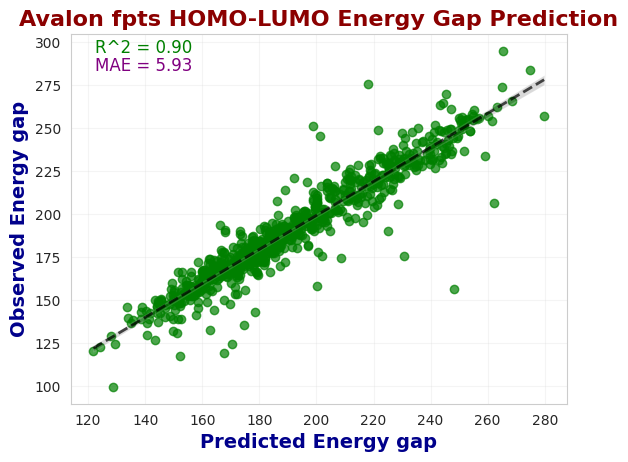

In [64]:
title_font = {"color" : "darkred", "weight" : "bold", "size" : 16}
axis_font = {"color" : "darkblue", "weight" : "bold", "size" : 14}

# Set the style
sns.set_style('whitegrid')

# Create a scatter plot with regression line
sns.regplot(x=y_pred, y=y_test,
            line_kws={"lw": 2, 'ls': '--', 'color': 'black', "alpha": 0.7},
            label='Regression Line',
            scatter_kws={'color': 'green', 'alpha': 0.7})

plt.xlabel('Predicted Energy gap', fontdict=axis_font)
plt.ylabel('Observed Energy gap', fontdict=axis_font)
plt.title("Avalon fpts HOMO-LUMO Energy Gap Prediction", fontdict=title_font)
plt.grid(alpha=0.2)

# Get the axis limits
x_limit = plt.xlim()
y_limit = plt.ylim()

# Display R^2 and MAE based on the proportions of the graph
plt.text(x_limit[0] + 0.05 * (x_limit[1] - x_limit[0]),
         y_limit[1] - 0.05 * (y_limit[1] - y_limit[0]),
         f'R^2 = {R2_lgbm:.2f}', fontsize=12, color='green')

plt.text(x_limit[0] + 0.05 * (x_limit[1] - x_limit[0]),
         y_limit[1] - 0.10 * (y_limit[1] - y_limit[0]),
         f'MAE = {MAE_lgbm:.2f}', fontsize=12, color='purple')

# Save to pdf
plt.savefig(f'predicted_vs_observed.pdf')


# Show the plot
plt.show()

#### 6.6.3 Residuals<a name = 22></a>

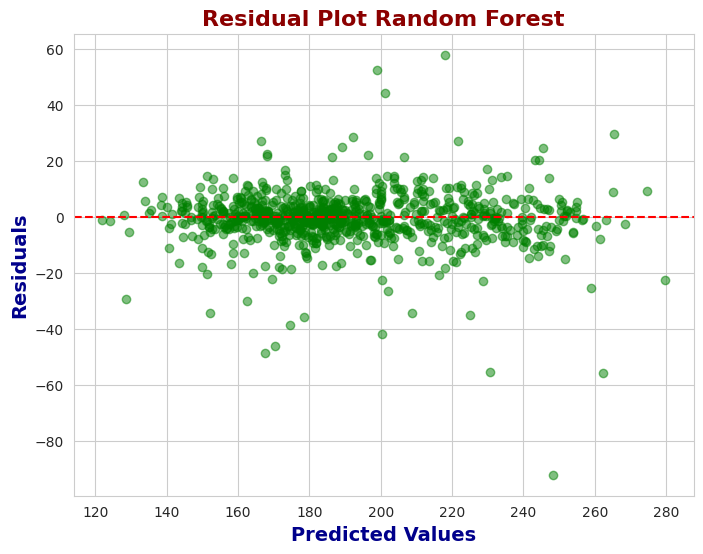

In [65]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.title('Residual Plot Random Forest', fontdict=title_font)
plt.xlabel('Predicted Values', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.savefig("residuals.pdf", bbox_inches='tight')
plt.show()

#### 6.6.4 Absolute Difference<a name = 23></a>

In [66]:
# Create a DataFrame with actual and predicted values
comparison = pd.DataFrame({
    'Actual Values': y_test,
    'Predicted Values': y_pred,
    'Absolute Difference': abs(y_test - y_pred)
})

comparison

,Actual Values,Predicted Values,Absolute Difference
0,189.286835,187.871163,1.415672
1,199.232225,200.553688,1.321463
2,169.528459,172.981122,3.452663
3,219.881664,217.396803,2.484861
4,211.161171,200.327907,10.833264
...,...,...,...
857,177.254977,185.049593,7.794616
858,270.098071,245.548654,24.549417
859,196.752309,196.146167,0.606142
860,175.150312,177.390153,2.239840


In [67]:
# Compute summary statistics on the "Difference" column
difference_statistics = comparison["Absolute Difference"].describe()

difference_statistics

count    862.000000
mean       5.927685
std        7.646920
min        0.004584
25%        1.615199
50%        3.664006
75%        7.207890
max       91.953261
Name: Absolute Difference, dtype: float64

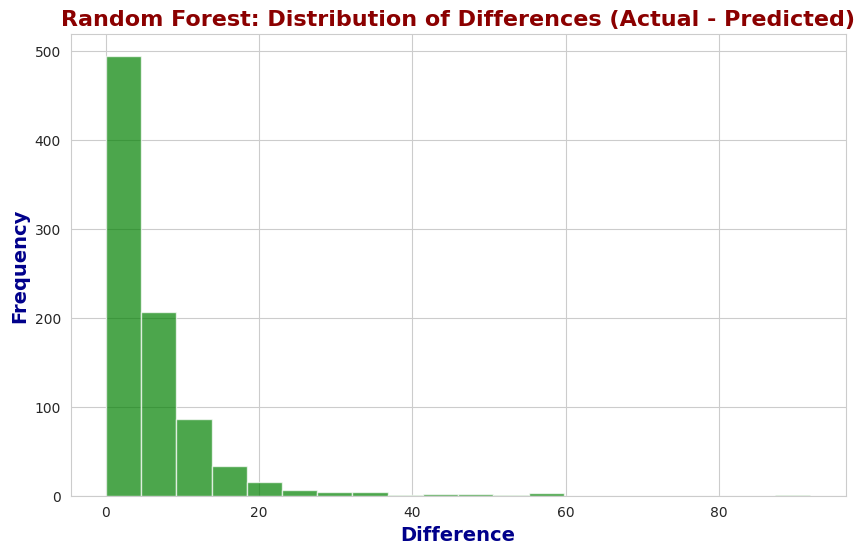

In [68]:
# Histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(comparison["Absolute Difference"], bins=20, color='green', alpha=0.7)
plt.title('Random Forest: Distribution of Differences (Actual - Predicted)', fontdict=title_font)
plt.xlabel('Difference', fontdict=axis_font)
plt.ylabel('Frequency', fontdict=axis_font)
plt.grid(True)
plt.savefig("LGBM_difference.pdf", bbox_inches='tight')

plt.show()

## 7. Conclusions<a name = 24></a>

In this study, I employed a range of cheminformatics tools to develop a regression model aimed at predicting the HOMO-LUMO energy gap. This model was based on a dataset sourced from the already mentioned publication. I calculated the Avalon fingerprints for the dataset using four distinct nBits values: 512, 1024, 2048, and 4096. These fingerprints served as features to train two regression models: the Random Forest and the LGBMRegressor.

Of the two, the LGBMRegressor outperformed, particularly when using the 4096-bit fingerprint, achieving a Mean Squared Error (MSE) of 5.46 and an R2R2 value of 0.92. Subsequent predictions were made using a test set, from which the observed vs. predicted values and residuals were scrutinized.

In summary, the algorithm appears proficient in predicting HOMO-LUMO energy gaps. However, as with many models, there's always room for enhancement, like reducing the number of features. It's also worth noting that data quality is one of the most important part in designing a predictive model. Unfortunately, this is a factor we often don't have much influence over.